In [1]:
!pip install torch torchvision matplotlib tqdm seaborn ultralytics --quiet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 84.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 71.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 34.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 8.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 29.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 13.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 8.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 81.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 41.2 MB/s eta 0:00:00


In [2]:
from ultralytics import YOLO
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import numpy as np
import copy
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import seaborn as sns

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [4]:
import torch.nn as nn
import torchvision.models as models
from torchvision.models import ResNet18_Weights, VGG16_Weights
from tqdm.notebook import tqdm
import torch.nn.functional as F

# -----------------
# 1a. Early-Exit ResNet18 (Streamlined to 2 Exits)
# -----------------
class EarlyExitResNet(nn.Module):
    def __init__(self, num_classes=10):
        super(EarlyExitResNet, self).__init__()
        self.resnet = models.resnet18(weights=ResNet18_Weights.DEFAULT)
        num_ftrs = self.resnet.fc.in_features
        self.resnet.fc = nn.Linear(num_ftrs, num_classes)

        # --- ARCHITECTURE CHANGE: Dissect model for a single, deeper early exit ---
        self.feature_extractor = nn.Sequential(
            self.resnet.conv1, self.resnet.bn1, self.resnet.relu,
            self.resnet.maxpool, self.resnet.layer1
        )
        self.block1 = nn.Sequential(self.resnet.layer2, self.resnet.layer3) # Output channels: 256
        self.block2 = self.resnet.layer4 # Output channels: 512

        # --- ARCHITECTURE CHANGE: Define only one early exit head ---
        self.exit1 = nn.Sequential(nn.AdaptiveAvgPool2d(1), nn.Flatten(), nn.Linear(256, num_classes))
        self.final_classifier = nn.Sequential(self.resnet.avgpool, nn.Flatten(), self.resnet.fc)

    def forward(self, x):
        features_for_predictor = self.feature_extractor(x)
        x1 = self.block1(features_for_predictor)
        exit1_out = self.exit1(x1)
        x2 = self.block2(x1)
        final_out = self.final_classifier(x2)
        # Return 2 exit logits
        return [exit1_out, final_out], features_for_predictor

# -----------------
# 1b. Early-Exit VGG16 (Streamlined to 3 Exits)
# -----------------
class EarlyExitVGG(nn.Module):
    def __init__(self, num_classes=10):
        super(EarlyExitVGG, self).__init__()
        self.vgg = models.vgg16(weights=VGG16_Weights.DEFAULT)
        num_ftrs = self.vgg.classifier[6].in_features
        self.vgg.classifier[6] = nn.Linear(num_ftrs, num_classes)

        # --- ARCHITECTURE CHANGE: Dissect model to remove the first exit ---
        self.feature_extractor = self.vgg.features[:10] # For predictor
        self.block1 = self.vgg.features[10:17] # Output channels: 256
        self.block2 = self.vgg.features[17:24] # Output channels: 512
        self.block3 = self.vgg.features[24:]   # Output channels: 512

        # --- ARCHITECTURE CHANGE: Define two early exit heads ---
        self.exit1 = nn.Sequential(nn.AdaptiveAvgPool2d(1), nn.Flatten(), nn.Linear(256, num_classes))
        self.exit2 = nn.Sequential(nn.AdaptiveAvgPool2d(1), nn.Flatten(), nn.Linear(512, num_classes))
        self.final_classifier = nn.Sequential(self.vgg.avgpool, nn.Flatten(), self.vgg.classifier)

    def forward(self, x):
        features_for_predictor = self.feature_extractor(x)
        x1 = self.block1(features_for_predictor)
        exit1_out = self.exit1(x1)
        x2 = self.block2(x1)
        exit2_out = self.exit2(x2)
        x3 = self.block3(x2)
        final_out = self.final_classifier(x3)
        # Return 3 exit logits
        return [exit1_out, exit2_out, final_out], features_for_predictor

# -----------------
# 1c. Early-Exit MobileNetV2 (Streamlined to 2 Exits)
# -----------------
class EarlyExitMobileNet(nn.Module):
    def __init__(self, num_classes=10):
        super(EarlyExitMobileNet, self).__init__()
        self.mobilenet = models.mobilenet_v2(weights="IMAGENET1K_V1")
        num_ftrs = self.mobilenet.classifier[1].in_features
        self.mobilenet.classifier[1] = nn.Linear(num_ftrs, num_classes)

        # --- ARCHITECTURE CHANGE: Dissect model for a single, deeper early exit ---
        self.feature_extractor = self.mobilenet.features[:4] # For predictor
        self.block1 = self.mobilenet.features[4:14] # Output channels: 96
        self.block2 = self.mobilenet.features[14:]  # Output channels: 1280

        # --- ARCHITECTURE CHANGE: Define only one early exit head ---
        self.exit1 = nn.Sequential(nn.AdaptiveAvgPool2d(1), nn.Flatten(), nn.Linear(96, num_classes))
        self.final_classifier = self.mobilenet.classifier

    def forward(self, x):
        features_for_predictor = self.feature_extractor(x)
        x1 = self.block1(features_for_predictor)
        exit1_out = self.exit1(x1)
        x2 = self.block2(x1)
        x2 = nn.functional.adaptive_avg_pool2d(x2, (1, 1)).reshape(x2.shape[0], -1)
        final_out = self.final_classifier(x2)
        # Return 2 exit logits
        return [exit1_out, final_out], features_for_predictor

In [5]:
# Upfront Exit Predictor V2 (Flexible for different feature map sizes)
class ExitPredictorV2(nn.Module):
    def __init__(self, input_channels, spatial_dim, num_exits=4):
        super(ExitPredictorV2, self).__init__()
        
        self.conv_layers = nn.Sequential(
            nn.Conv2d(input_channels, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(32, 16, kernel_size=3, padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        
        # Calculate the flattened size after conv layers
        flattened_size = 16 * (spatial_dim // 4) * (spatial_dim // 4)
        
        self.fc_layers = nn.Sequential(
            nn.Flatten(),
            nn.Linear(flattened_size, 128),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(128, num_exits)
        )

    def forward(self, x):
        x = self.conv_layers(x)
        x = self.fc_layers(x)
        return x

In [6]:
import numpy as np
from torch.utils.data import Subset # <-- ADD THIS IMPORT
import torchvision.transforms as transforms

# MODIFIED Data Loading function with an option for a subset
def load_cifar10_data(batch_size=64, subset_size=None):
    transform = transforms.Compose([
        transforms.Resize(224),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                             std=[0.229, 0.224, 0.225])
    ])
    
    test_transform = transforms.Compose([
        transforms.Resize(224),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                             std=[0.229, 0.224, 0.225])
    ])
    
    train_dataset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
    
    # Create a subset if a size is specified
    if subset_size:
        indices = np.random.choice(len(train_dataset), subset_size, replace=False)
        train_dataset = Subset(train_dataset, indices)

    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
    
    test_dataset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=test_transform)
    test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=2)
    
    return train_loader, test_loader

In [7]:
# -----------------
# 2. Updated Pre-training Function (Handles different exit counts)
# -----------------
def pretrain_cnn(model, train_loader, num_epochs_phase1=30, num_epochs_phase2=20):
    model_name = model.module.__class__.__name__ if isinstance(model, nn.DataParallel) else model.__class__.__name__
    print(f"--- Stage 1, Phase 1: Fine-tuning Exit Heads for {model_name} ---")
    model.to(device)
    unwrapped_model = model.module if isinstance(model, nn.DataParallel) else model
    for param in unwrapped_model.parameters(): param.requires_grad = False
    
    # --- DYNAMICALLY SET TRAINABLE LAYERS AND WEIGHTS ---
    if isinstance(unwrapped_model, EarlyExitResNet):
        trainable_layers = [unwrapped_model.exit1, unwrapped_model.final_classifier]
        exit_weights = torch.tensor([0.7, 1.0]).to(device)
    elif isinstance(unwrapped_model, EarlyExitVGG):
        trainable_layers = [unwrapped_model.exit1, unwrapped_model.exit2, unwrapped_model.final_classifier]
        exit_weights = torch.tensor([0.5, 0.8, 1.0]).to(device)
    elif isinstance(unwrapped_model, EarlyExitMobileNet):
        trainable_layers = [unwrapped_model.exit1, unwrapped_model.final_classifier]
        exit_weights = torch.tensor([0.7, 1.0]).to(device)
    
    for layer in trainable_layers:
        for param in layer.parameters(): param.requires_grad = True
    
    model.train()
    optimizer = torch.optim.AdamW(filter(lambda p: p.requires_grad, model.parameters()), lr=0.001)

    for epoch in range(num_epochs_phase1):
        progress_bar = tqdm(train_loader, desc=f'Phase 1 Epoch {epoch+1}/{num_epochs_phase1}')
        for data, target in progress_bar:
            data, target = data.to(device), target.to(device)
            optimizer.zero_grad()
            exits, _ = model(data)
            if isinstance(model, nn.DataParallel): exits = [e.to(device) for e in exits]
            loss = sum(exit_weights[i] * F.cross_entropy(e, target) for i, e in enumerate(exits))
            loss.backward()
            optimizer.step()
            progress_bar.set_postfix({'loss': f'{loss.item():.4f}'})

    print(f"\n--- Stage 1, Phase 2: Fine-tuning all layers for {model_name} ---")
    for param in model.parameters(): param.requires_grad = True
    optimizer = torch.optim.AdamW(model.parameters(), lr=1e-5)

    for epoch in range(num_epochs_phase2):
        progress_bar = tqdm(train_loader, desc=f'Phase 2 Epoch {epoch+1}/{num_epochs_phase2}')
        for data, target in progress_bar:
            data, target = data.to(device), target.to(device)
            optimizer.zero_grad()
            exits, _ = model(data)
            if isinstance(model, nn.DataParallel): exits = [e.to(device) for e in exits]
            loss = sum(exit_weights[i] * F.cross_entropy(e, target) for i, e in enumerate(exits))
            loss.backward()
            optimizer.step()
            progress_bar.set_postfix({'loss': f'{loss.item():.4f}'})
    print("Two-phase fine-tuning completed.")

In [8]:
# 5. Stage 2: Generate Labels for the ExitPredictor
def generate_exit_labels(main_model, data_loader, confidence_threshold=0.95):
    print("\n--- Stage 2: Generating labels for ExitPredictor ---")
    main_model.eval()
    features_list = []
    labels_list = []

    with torch.no_grad():
        for inputs, targets in tqdm(data_loader, desc="Generating Labels"):
            inputs, targets = inputs.to(device), targets.to(device)
            exits, features = main_model(inputs)

            for i in range(inputs.size(0)):
                target_label = targets[i]
                # Default to the last exit if no early exit is confident and correct
                optimal_exit = len(exits) - 1

                for j, exit_output in enumerate(exits):
                    pred = exit_output[i].argmax()
                    confidence = F.softmax(exit_output[i], dim=0)[pred]
                    if pred == target_label and confidence >= confidence_threshold:
                        optimal_exit = j
                        break # Found the earliest suitable exit

                # Store features on CPU to save GPU memory
                features_list.append(features[i].cpu())
                labels_list.append(optimal_exit)

    # Stack all features and create labels tensor
    return torch.stack(features_list), torch.tensor(labels_list, dtype=torch.long)

In [9]:
def train_exit_predictor_incrementally(main_model, predictor, label_gen_loader, num_epochs=10):
    print(f"\\n--- Stages 2 & 3: Incrementally generating labels and training ExitPredictor ---")
    
    main_model.eval()
    predictor.to(device)
    predictor.train()
    
    optimizer = torch.optim.AdamW(predictor.parameters(), lr=0.001)

    for epoch in range(num_epochs):
        total_loss = 0
        correct = 0
        total = 0
        progress_bar = tqdm(label_gen_loader, desc=f'Epoch {epoch+1}/{num_epochs}')
        
        for inputs, targets in progress_bar:
            inputs, targets = inputs.to(device), targets.to(device)
            
            with torch.no_grad():
                exits, features = main_model(inputs)
                unwrapped_model = main_model.module if isinstance(main_model, nn.DataParallel) else main_model
                
                batch_labels = []
                for i in range(inputs.size(0)):
                    target_label = targets[i]
                    optimal_exit = len(exits) - 1
                    for j, exit_output in enumerate(exits):
                        pred = exit_output[i].argmax()
                        confidence = F.softmax(exit_output[i], dim=0)[pred]
                        if pred == target_label and confidence >= 0.95:
                            optimal_exit = j
                            break
                    batch_labels.append(optimal_exit)
            
            batch_labels = torch.tensor(batch_labels, dtype=torch.long).to(device)

            optimizer.zero_grad()
            outputs = predictor(features.to(device))
            loss = F.cross_entropy(outputs, batch_labels)
            loss.backward()
            optimizer.step()

            total_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += batch_labels.size(0)
            correct += (predicted == batch_labels).sum().item()
            accuracy = 100 * correct / total
            progress_bar.set_postfix({'loss': f'{total_loss / (progress_bar.n + 1):.4f}', 'acc': f'{accuracy:.2f}%'})
            
    print("ExitPredictor training completed.")
    
    # --- CORRECTED: Generate all labels for the final distribution plot ---
    # This runs after training is complete, using the fully trained main model.
    print("Generating final label distribution for plotting...")
    all_labels = []
    main_model.eval() # Ensure model is in eval mode
    with torch.no_grad():
        for inputs, targets in tqdm(label_gen_loader, desc="Generating final labels"):
            inputs, targets = inputs.to(device), targets.to(device)
            
            # We only need the exit logits for this step, not the features
            exits, _ = main_model(inputs)
            
            for i in range(inputs.size(0)):
                target_label = targets[i]
                optimal_exit = len(exits) - 1
                for j, exit_output in enumerate(exits):
                    pred = exit_output[i].argmax()
                    confidence = F.softmax(exit_output[i], dim=0)[pred]
                    if pred == target_label and confidence >= 0.95:
                        optimal_exit = j
                        break
                all_labels.append(optimal_exit)

    return torch.tensor(all_labels, dtype=torch.long)

In [10]:
def evaluate_with_predictor(main_model, predictor, test_loader, cost_per_exit, num_exits): # <-- ADDED num_exits
    print("\\n--- Final Evaluation ---")
    main_model.eval()
    predictor.eval()
    
    correct, total = 0, 0
    exit_counts = [0] * num_exits # <-- USE num_exits
    total_cost = 0

    with torch.no_grad():
        for images, labels in tqdm(test_loader, desc='Evaluating'):
            images, labels = images.to(device), labels.to(device)
            exits, features = main_model(images)
            predicted_exit_indices = predictor(features).argmax(dim=1)

            for i in range(images.size(0)):
                chosen_exit = predicted_exit_indices[i].item()
                exit_counts[chosen_exit] += 1
                final_prediction = exits[chosen_exit][i].argmax()
                if final_prediction == labels[i]:
                    correct += 1
                total += 1
                total_cost += cost_per_exit[chosen_exit]

    accuracy = 100 * correct / total
    avg_cost = total_cost / total
    max_cost = cost_per_exit[-1]
    compute_saved = 100 * (1 - (avg_cost / max_cost))

    print(f'\\nOverall Accuracy: {accuracy:.2f}%')
    exit_dist_percent = [f'{(count/total*100):.1f}%' for count in exit_counts]
    print(f'Exit Distribution: {exit_dist_percent}')
    print(f'Average Computational Cost: {avg_cost:.2f} (relative units)')
    print(f'Total Cost without Early Exit: {max_cost:.2f}')
    print(f'Estimated Compute Saved: {compute_saved:.2f}%')
    return {'accuracy': accuracy, 'exit_distribution': [count/total*100 for count in exit_counts]}

In [11]:
def visualize_exit_decisions(main_model, predictor, test_loader, num_exits, num_samples=25): # <-- ADDED num_exits
    classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')
    main_model.eval()
    predictor.eval()

    images, labels = next(iter(test_loader))
    images, labels = images[:num_samples].to(device), labels[:num_samples].to(device)

    with torch.no_grad():
        exits, features = main_model(images)
        predicted_exits = predictor(features).argmax(dim=1)

    fig, axes = plt.subplots(5, 5, figsize=(15, 15))
    axes = axes.ravel()

    for i in range(num_samples):
        exit_choice = predicted_exits[i].item()
        logits = exits[exit_choice][i]
        confidence = F.softmax(logits, dim=0).max().item()
        prediction = logits.argmax().item()

        img = images[i].cpu().numpy().transpose(1, 2, 0)
        mean = np.array([0.485, 0.456, 0.406])
        std = np.array([0.229, 0.224, 0.225])
        img = std * img + mean
        img = np.clip(img, 0, 1)

        axes[i].imshow(img)
        axes[i].axis('off')
        color = 'green' if prediction == labels[i].item() else 'red'
        title = f'True: {classes[labels[i]]}\nPred: {classes[prediction]}\nExit: {exit_choice + 1} (Conf: {confidence:.2f})'
        axes[i].set_title(title, color=color)

    plt.tight_layout()
    plt.show()

In [12]:
import numpy as np
import matplotlib.pyplot as plt
import torch

def plot_per_class_accuracy(model, data_loader, num_exits=4, device="cuda"):
    classes = ('plane', 'car', 'bird', 'cat', 'deer', 
               'dog', 'frog', 'horse', 'ship', 'truck')

    model.eval()
    correct = np.zeros((num_exits, len(classes)))
    total = np.zeros(len(classes))

    with torch.no_grad():
        for images, labels in data_loader:
            images, labels = images.to(device), labels.to(device)
            
            # Unwrap the model if it's wrapped in DataParallel
            unwrapped_model = model.module if isinstance(model, nn.DataParallel) else model
            exits, _ = unwrapped_model(images)
            
            # --- FIX: First, update total counts for this batch ---
            # This loop runs only once per image in the batch.
            for label in labels:
                total[label.item()] += 1

            # --- Then, update correct counts for each exit ---
            for j in range(num_exits):
                preds = exits[j].argmax(dim=1)
                for i, label in enumerate(labels):
                    # We no longer increment total here
                    if preds[i] == label:
                        correct[j][label.item()] += 1

    # This calculation is now correct because 'total' is no longer inflated
    acc_per_class = 100 * correct / total

    # --- Plot ---
    x = np.arange(len(classes))
    width = 0.2
    plt.figure(figsize=(14, 7))
    for j in range(num_exits):
        plt.bar(x + j*width, acc_per_class[j], width, label=f'Exit {j+1}')
    plt.xticks(x + width*(num_exits-1)/2, classes)
    plt.ylabel("Accuracy (%)")
    plt.title("Per-Class Accuracy at Each Exit")
    plt.legend()
    plt.show()

In [13]:
def plot_exit_distribution(labels, num_exits): # <-- ADDED num_exits
    exit_counts = torch.bincount(labels, minlength=num_exits).cpu().numpy()
    exit_percentages = 100 * exit_counts / exit_counts.sum()

    plt.figure(figsize=(8, 6))
    plt.bar([f"Exit {i+1}" for i in range(num_exits)], exit_percentages)
    plt.ylabel("Percentage of Samples (%)")
    plt.title("Exit Point Distribution Based on Training Data Labels")
    plt.show()

In [14]:
# New function to evaluate only the main model's final exit
def evaluate_main_model_only(main_model, test_loader, device="cuda"):
    print("\\n--- Intermediate Evaluation: Main Model Final Exit Accuracy ---")
    main_model.eval()
    correct = 0
    total = 0
    
    with torch.no_grad():
        for images, labels in tqdm(test_loader, desc='Evaluating Main Model'):
            images, labels = images.to(device), labels.to(device)
            
            # Get all exit predictions
            exits, _ = main_model(images)
            
            # We only care about the final exit for this evaluation
            final_exit_output = exits[-1]
            
            # Get the top prediction
            _, predicted = torch.max(final_exit_output.data, 1)
            
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = 100 * correct / total
    print(f"Accuracy of the main model's final exit on the test set: {accuracy:.2f}%")
    
    # Set the model back to train mode for the next stage
    main_model.train()
    return accuracy

In [15]:
# --- Fully flexible experiment pipeline ---
def run_experiment(model_class, model_name):
    print(f"\n{'='*30}\nRunning Experiment for: {model_name}\n{'='*30}")
    
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"Using device: {device}")
    
    train_loader, test_loader = load_cifar10_data(batch_size=256, subset_size=None)

    cnn_model = model_class()
    cnn_model.to(device)
    if torch.cuda.device_count() > 1:
      print(f"Let's use {torch.cuda.device_count()} GPUs!")
      cnn_model = nn.DataParallel(cnn_model)

    # --- DYNAMICALLY DETERMINE NUMBER OF EXITS ---
    dummy_input = torch.randn(2, 3, 224, 224).to(device)
    with torch.no_grad():
        exits_dummy, features_for_predictor = cnn_model(dummy_input)
    num_exits = len(exits_dummy)
    print(f"Detected {num_exits} total exits for this model.")
    
    pred_input_channels = features_for_predictor.shape[1]
    pred_spatial_dim = features_for_predictor.shape[2]
    
    exit_predictor = ExitPredictorV2(
        input_channels=pred_input_channels,
        spatial_dim=pred_spatial_dim,
        num_exits=num_exits
    )

    pretrain_cnn(cnn_model, train_loader, num_epochs_phase1=30, num_epochs_phase2=20)
    evaluate_main_model_only(cnn_model, test_loader, device=device)

    label_gen_loader = torch.utils.data.DataLoader(
        torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=test_loader.dataset.transform),
        batch_size=256, shuffle=True)
    
    final_labels = train_exit_predictor_incrementally(cnn_model, exit_predictor, label_gen_loader, num_epochs=20)

    # --- REPLACED: More Accurate, FLOPs-Based Cost Estimation ---
    if model_name == "ResNet18":
        # Based on FLOPs distribution; cost is heavily skewed towards later layers.
        cost_per_exit = [8.5, 10.0] 
    elif model_name == "VGG16":
        # Based on an analysis of VGGNet's FLOPs per layer.
        cost_per_exit = [4.0, 7.5, 10.0] 
    elif model_name == "MobileNetV2":
        # Derived from the M-Add counts in the original MobileNetV2 paper.
        cost_per_exit = [7.0, 10.0]
        
    metrics = evaluate_with_predictor(cnn_model, exit_predictor, test_loader, cost_per_exit, num_exits=num_exits)
    visualize_exit_decisions(cnn_model, exit_predictor, test_loader, num_exits=num_exits)
    plot_per_class_accuracy(cnn_model, test_loader, num_exits=num_exits, device=device)
    if len(final_labels) > 0:
        plot_exit_distribution(final_labels, num_exits=num_exits)

    print(f"\n--- Experiment Complete for {model_name} ---")
    print(f"Final System Test Accuracy: {metrics['accuracy']:.2f}%")

    return cnn_model, exit_predictor, metrics


Running Experiment for: MobileNetV2
Using device: cuda


100%|██████████| 170M/170M [00:01<00:00, 103MB/s]
Downloading: "https://download.pytorch.org/models/mobilenet_v2-b0353104.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v2-b0353104.pth
100%|██████████| 13.6M/13.6M [00:00<00:00, 119MB/s]


Let's use 2 GPUs!
Detected 2 total exits for this model.
--- Stage 1, Phase 1: Fine-tuning Exit Heads for EarlyExitMobileNet ---


Phase 1 Epoch 1/30:   0%|          | 0/196 [00:00<?, ?it/s]

Phase 1 Epoch 2/30:   0%|          | 0/196 [00:00<?, ?it/s]

Phase 1 Epoch 3/30:   0%|          | 0/196 [00:00<?, ?it/s]

Phase 1 Epoch 4/30:   0%|          | 0/196 [00:00<?, ?it/s]

Phase 1 Epoch 5/30:   0%|          | 0/196 [00:00<?, ?it/s]

Phase 1 Epoch 6/30:   0%|          | 0/196 [00:00<?, ?it/s]

Phase 1 Epoch 7/30:   0%|          | 0/196 [00:00<?, ?it/s]

Phase 1 Epoch 8/30:   0%|          | 0/196 [00:00<?, ?it/s]

Phase 1 Epoch 9/30:   0%|          | 0/196 [00:00<?, ?it/s]

Phase 1 Epoch 10/30:   0%|          | 0/196 [00:00<?, ?it/s]

Phase 1 Epoch 11/30:   0%|          | 0/196 [00:00<?, ?it/s]

Phase 1 Epoch 12/30:   0%|          | 0/196 [00:00<?, ?it/s]

Phase 1 Epoch 13/30:   0%|          | 0/196 [00:00<?, ?it/s]

Phase 1 Epoch 14/30:   0%|          | 0/196 [00:00<?, ?it/s]

Phase 1 Epoch 15/30:   0%|          | 0/196 [00:00<?, ?it/s]

Phase 1 Epoch 16/30:   0%|          | 0/196 [00:00<?, ?it/s]

Phase 1 Epoch 17/30:   0%|          | 0/196 [00:00<?, ?it/s]

Phase 1 Epoch 18/30:   0%|          | 0/196 [00:00<?, ?it/s]

Phase 1 Epoch 19/30:   0%|          | 0/196 [00:00<?, ?it/s]

Phase 1 Epoch 20/30:   0%|          | 0/196 [00:00<?, ?it/s]

Phase 1 Epoch 21/30:   0%|          | 0/196 [00:00<?, ?it/s]

Phase 1 Epoch 22/30:   0%|          | 0/196 [00:00<?, ?it/s]

Phase 1 Epoch 23/30:   0%|          | 0/196 [00:00<?, ?it/s]

Phase 1 Epoch 24/30:   0%|          | 0/196 [00:00<?, ?it/s]

Phase 1 Epoch 25/30:   0%|          | 0/196 [00:00<?, ?it/s]

Phase 1 Epoch 26/30:   0%|          | 0/196 [00:00<?, ?it/s]

Phase 1 Epoch 27/30:   0%|          | 0/196 [00:00<?, ?it/s]

Phase 1 Epoch 28/30:   0%|          | 0/196 [00:00<?, ?it/s]

Phase 1 Epoch 29/30:   0%|          | 0/196 [00:00<?, ?it/s]

Phase 1 Epoch 30/30:   0%|          | 0/196 [00:00<?, ?it/s]


--- Stage 1, Phase 2: Fine-tuning all layers for EarlyExitMobileNet ---


Phase 2 Epoch 1/20:   0%|          | 0/196 [00:00<?, ?it/s]

Phase 2 Epoch 2/20:   0%|          | 0/196 [00:00<?, ?it/s]

Phase 2 Epoch 3/20:   0%|          | 0/196 [00:00<?, ?it/s]

Phase 2 Epoch 4/20:   0%|          | 0/196 [00:00<?, ?it/s]

Phase 2 Epoch 5/20:   0%|          | 0/196 [00:00<?, ?it/s]

Phase 2 Epoch 6/20:   0%|          | 0/196 [00:00<?, ?it/s]

Phase 2 Epoch 7/20:   0%|          | 0/196 [00:00<?, ?it/s]

Phase 2 Epoch 8/20:   0%|          | 0/196 [00:00<?, ?it/s]

Phase 2 Epoch 9/20:   0%|          | 0/196 [00:00<?, ?it/s]

Phase 2 Epoch 10/20:   0%|          | 0/196 [00:00<?, ?it/s]

Phase 2 Epoch 11/20:   0%|          | 0/196 [00:00<?, ?it/s]

Phase 2 Epoch 12/20:   0%|          | 0/196 [00:00<?, ?it/s]

Phase 2 Epoch 13/20:   0%|          | 0/196 [00:00<?, ?it/s]

Phase 2 Epoch 14/20:   0%|          | 0/196 [00:00<?, ?it/s]

Phase 2 Epoch 15/20:   0%|          | 0/196 [00:00<?, ?it/s]

Phase 2 Epoch 16/20:   0%|          | 0/196 [00:00<?, ?it/s]

Phase 2 Epoch 17/20:   0%|          | 0/196 [00:00<?, ?it/s]

Phase 2 Epoch 18/20:   0%|          | 0/196 [00:00<?, ?it/s]

Phase 2 Epoch 19/20:   0%|          | 0/196 [00:00<?, ?it/s]

Phase 2 Epoch 20/20:   0%|          | 0/196 [00:00<?, ?it/s]

Two-phase fine-tuning completed.
\n--- Intermediate Evaluation: Main Model Final Exit Accuracy ---


Evaluating Main Model:   0%|          | 0/40 [00:00<?, ?it/s]

Accuracy of the main model's final exit on the test set: 93.11%
\n--- Stages 2 & 3: Incrementally generating labels and training ExitPredictor ---


Epoch 1/20:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 2/20:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 3/20:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 4/20:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 5/20:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 6/20:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 7/20:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 8/20:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 9/20:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 10/20:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 11/20:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 12/20:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 13/20:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 14/20:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 15/20:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 16/20:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 17/20:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 18/20:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 19/20:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 20/20:   0%|          | 0/196 [00:00<?, ?it/s]

ExitPredictor training completed.
Generating final label distribution for plotting...


Generating final labels:   0%|          | 0/196 [00:00<?, ?it/s]

\n--- Final Evaluation ---


Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

\nOverall Accuracy: 93.11%
Exit Distribution: ['0.0%', '100.0%']
Average Computational Cost: 10.00 (relative units)
Total Cost without Early Exit: 10.00
Estimated Compute Saved: 0.00%


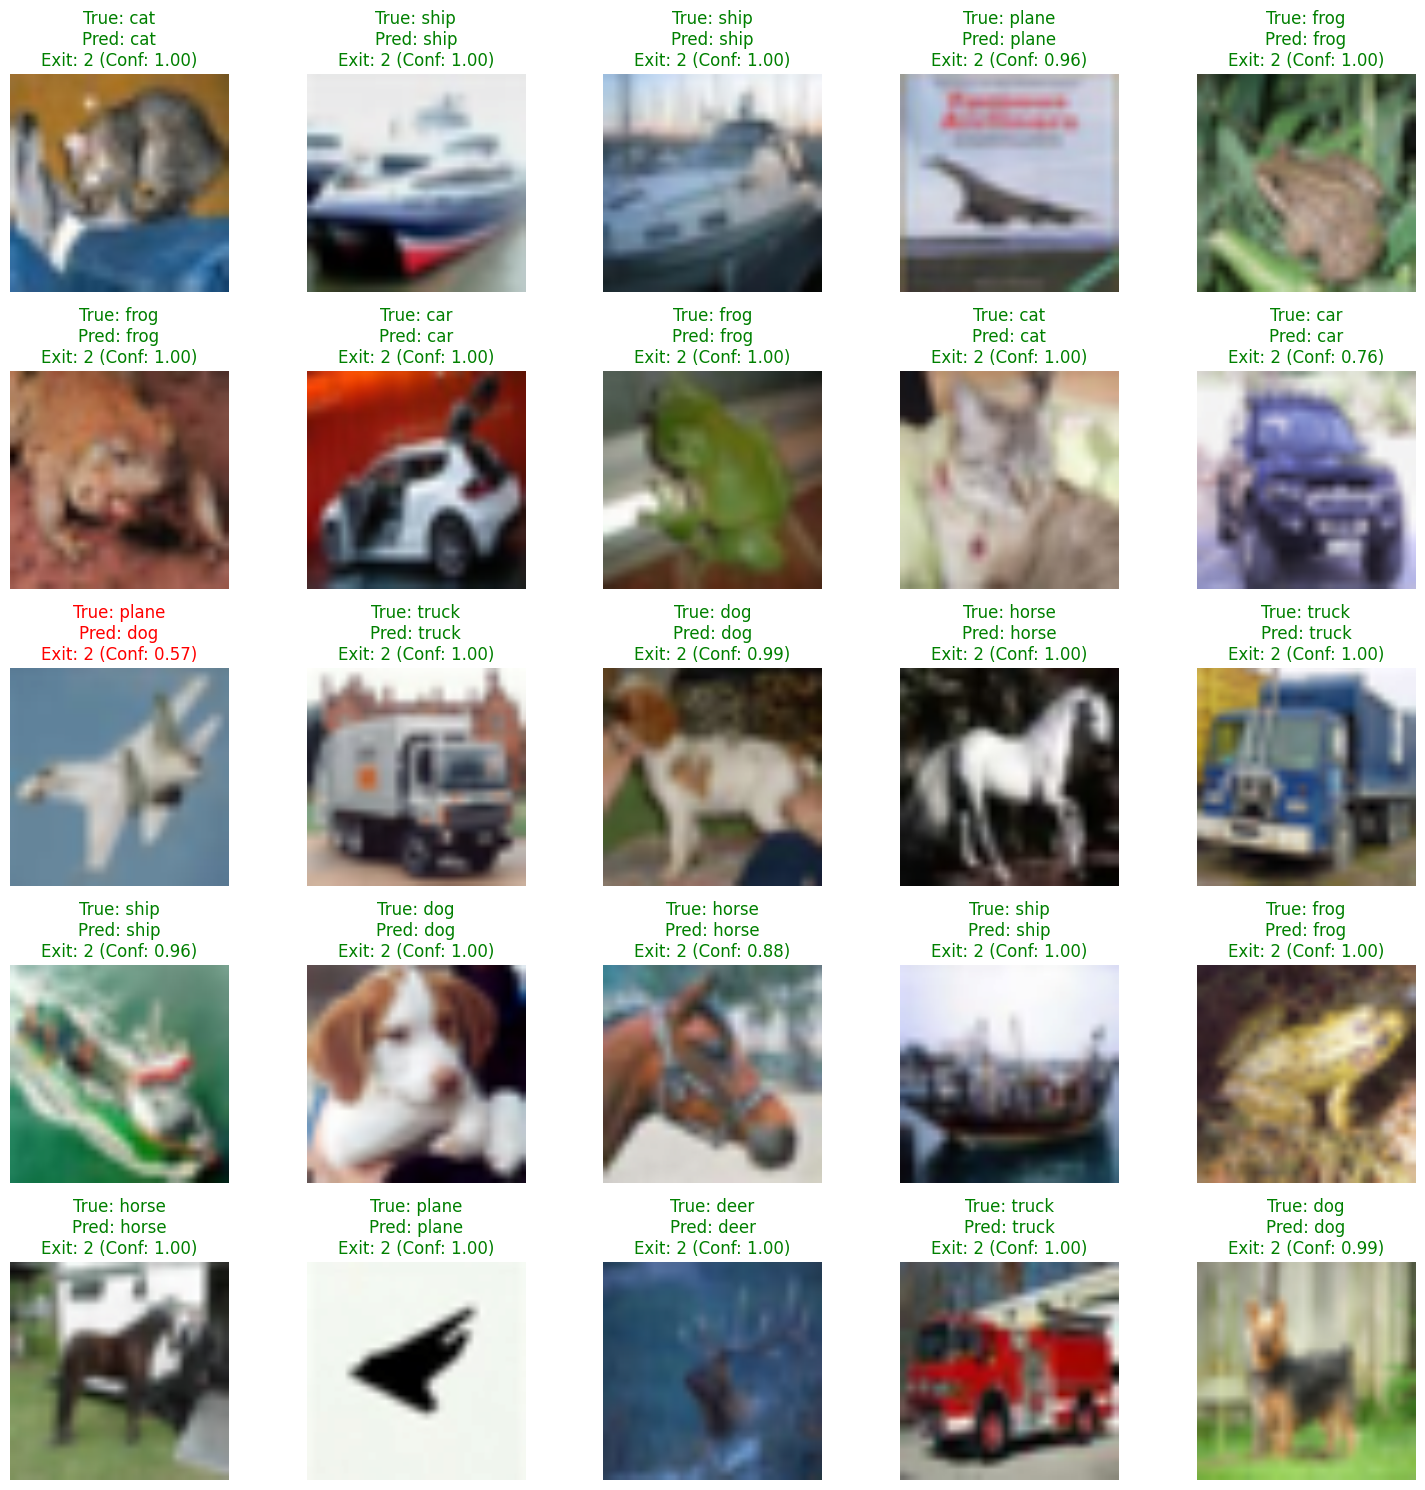

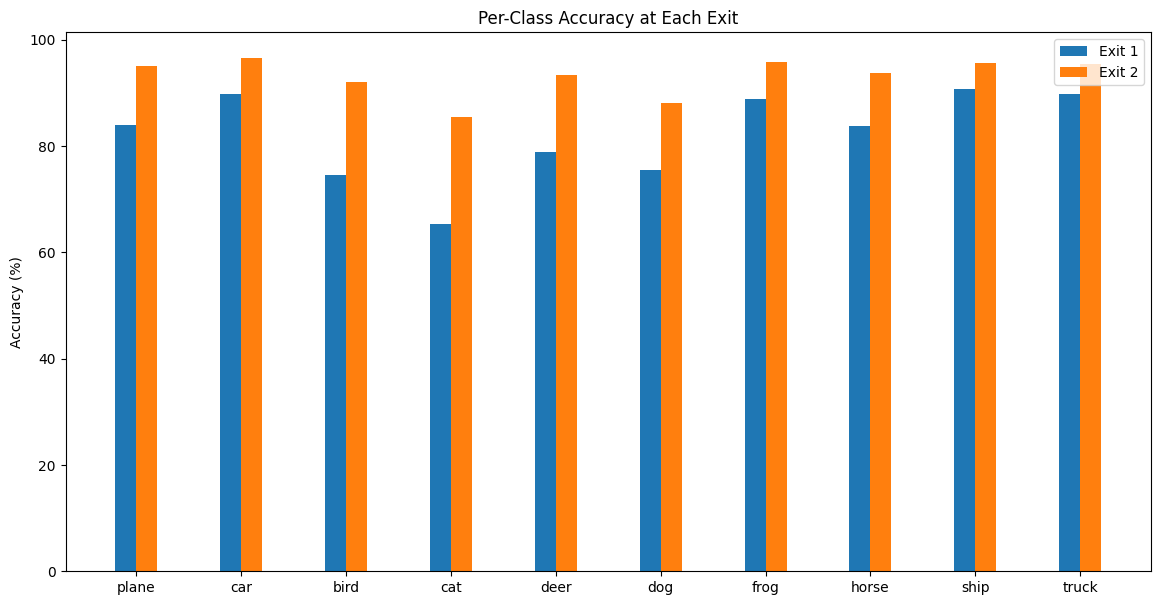

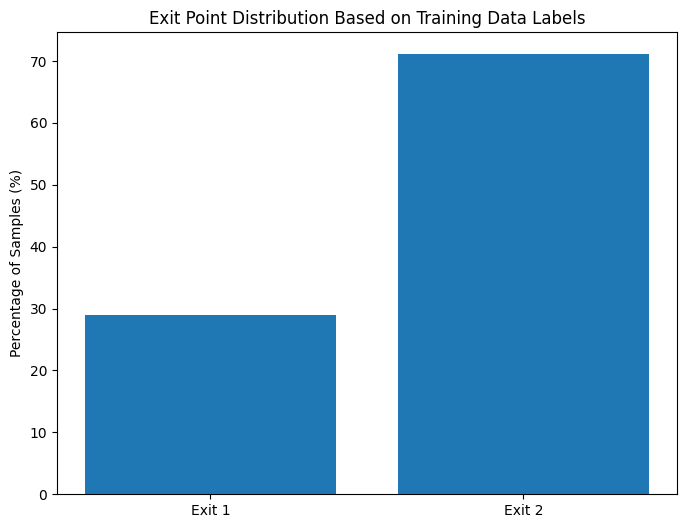


--- Experiment Complete for MobileNetV2 ---
Final System Test Accuracy: 93.11%


In [16]:
mobilenet_model, mobilenet_predictor, mobilenet_metrics = run_experiment(EarlyExitMobileNet, "MobileNetV2")


Running Experiment for: ResNet18
Using device: cuda


Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 159MB/s]


Let's use 2 GPUs!
Detected 2 total exits for this model.
--- Stage 1, Phase 1: Fine-tuning Exit Heads for EarlyExitResNet ---


Phase 1 Epoch 1/30:   0%|          | 0/196 [00:00<?, ?it/s]

Phase 1 Epoch 2/30:   0%|          | 0/196 [00:00<?, ?it/s]

Phase 1 Epoch 3/30:   0%|          | 0/196 [00:00<?, ?it/s]

Phase 1 Epoch 4/30:   0%|          | 0/196 [00:00<?, ?it/s]

Phase 1 Epoch 5/30:   0%|          | 0/196 [00:00<?, ?it/s]

Phase 1 Epoch 6/30:   0%|          | 0/196 [00:00<?, ?it/s]

Phase 1 Epoch 7/30:   0%|          | 0/196 [00:00<?, ?it/s]

Phase 1 Epoch 8/30:   0%|          | 0/196 [00:00<?, ?it/s]

Phase 1 Epoch 9/30:   0%|          | 0/196 [00:00<?, ?it/s]

Phase 1 Epoch 10/30:   0%|          | 0/196 [00:00<?, ?it/s]

Phase 1 Epoch 11/30:   0%|          | 0/196 [00:00<?, ?it/s]

Phase 1 Epoch 12/30:   0%|          | 0/196 [00:00<?, ?it/s]

Phase 1 Epoch 13/30:   0%|          | 0/196 [00:00<?, ?it/s]

Phase 1 Epoch 14/30:   0%|          | 0/196 [00:00<?, ?it/s]

Phase 1 Epoch 15/30:   0%|          | 0/196 [00:00<?, ?it/s]

Phase 1 Epoch 16/30:   0%|          | 0/196 [00:00<?, ?it/s]

Phase 1 Epoch 17/30:   0%|          | 0/196 [00:00<?, ?it/s]

Phase 1 Epoch 18/30:   0%|          | 0/196 [00:00<?, ?it/s]

Phase 1 Epoch 19/30:   0%|          | 0/196 [00:00<?, ?it/s]

Phase 1 Epoch 20/30:   0%|          | 0/196 [00:00<?, ?it/s]

Phase 1 Epoch 21/30:   0%|          | 0/196 [00:00<?, ?it/s]

Phase 1 Epoch 22/30:   0%|          | 0/196 [00:00<?, ?it/s]

Phase 1 Epoch 23/30:   0%|          | 0/196 [00:00<?, ?it/s]

Phase 1 Epoch 24/30:   0%|          | 0/196 [00:00<?, ?it/s]

Phase 1 Epoch 25/30:   0%|          | 0/196 [00:00<?, ?it/s]

Phase 1 Epoch 26/30:   0%|          | 0/196 [00:00<?, ?it/s]

Phase 1 Epoch 27/30:   0%|          | 0/196 [00:00<?, ?it/s]

Phase 1 Epoch 28/30:   0%|          | 0/196 [00:00<?, ?it/s]

Phase 1 Epoch 29/30:   0%|          | 0/196 [00:00<?, ?it/s]

Phase 1 Epoch 30/30:   0%|          | 0/196 [00:00<?, ?it/s]


--- Stage 1, Phase 2: Fine-tuning all layers for EarlyExitResNet ---


Phase 2 Epoch 1/20:   0%|          | 0/196 [00:00<?, ?it/s]

Phase 2 Epoch 2/20:   0%|          | 0/196 [00:00<?, ?it/s]

Phase 2 Epoch 3/20:   0%|          | 0/196 [00:00<?, ?it/s]

Phase 2 Epoch 4/20:   0%|          | 0/196 [00:00<?, ?it/s]

Phase 2 Epoch 5/20:   0%|          | 0/196 [00:00<?, ?it/s]

Phase 2 Epoch 6/20:   0%|          | 0/196 [00:00<?, ?it/s]

Phase 2 Epoch 7/20:   0%|          | 0/196 [00:00<?, ?it/s]

Phase 2 Epoch 8/20:   0%|          | 0/196 [00:00<?, ?it/s]

Phase 2 Epoch 9/20:   0%|          | 0/196 [00:00<?, ?it/s]

Phase 2 Epoch 10/20:   0%|          | 0/196 [00:00<?, ?it/s]

Phase 2 Epoch 11/20:   0%|          | 0/196 [00:00<?, ?it/s]

Phase 2 Epoch 12/20:   0%|          | 0/196 [00:00<?, ?it/s]

Phase 2 Epoch 13/20:   0%|          | 0/196 [00:00<?, ?it/s]

Phase 2 Epoch 14/20:   0%|          | 0/196 [00:00<?, ?it/s]

Phase 2 Epoch 15/20:   0%|          | 0/196 [00:00<?, ?it/s]

Phase 2 Epoch 16/20:   0%|          | 0/196 [00:00<?, ?it/s]

Phase 2 Epoch 17/20:   0%|          | 0/196 [00:00<?, ?it/s]

Phase 2 Epoch 18/20:   0%|          | 0/196 [00:00<?, ?it/s]

Phase 2 Epoch 19/20:   0%|          | 0/196 [00:00<?, ?it/s]

Phase 2 Epoch 20/20:   0%|          | 0/196 [00:00<?, ?it/s]

Two-phase fine-tuning completed.
\n--- Intermediate Evaluation: Main Model Final Exit Accuracy ---


Evaluating Main Model:   0%|          | 0/40 [00:00<?, ?it/s]

Accuracy of the main model's final exit on the test set: 93.30%
\n--- Stages 2 & 3: Incrementally generating labels and training ExitPredictor ---


Epoch 1/20:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 2/20:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 3/20:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 4/20:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 5/20:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 6/20:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 7/20:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 8/20:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 9/20:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 10/20:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 11/20:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 12/20:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 13/20:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 14/20:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 15/20:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 16/20:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 17/20:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 18/20:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 19/20:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 20/20:   0%|          | 0/196 [00:00<?, ?it/s]

ExitPredictor training completed.
Generating final label distribution for plotting...


Generating final labels:   0%|          | 0/196 [00:00<?, ?it/s]

\n--- Final Evaluation ---


Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

\nOverall Accuracy: 93.30%
Exit Distribution: ['0.0%', '100.0%']
Average Computational Cost: 10.00 (relative units)
Total Cost without Early Exit: 10.00
Estimated Compute Saved: 0.00%


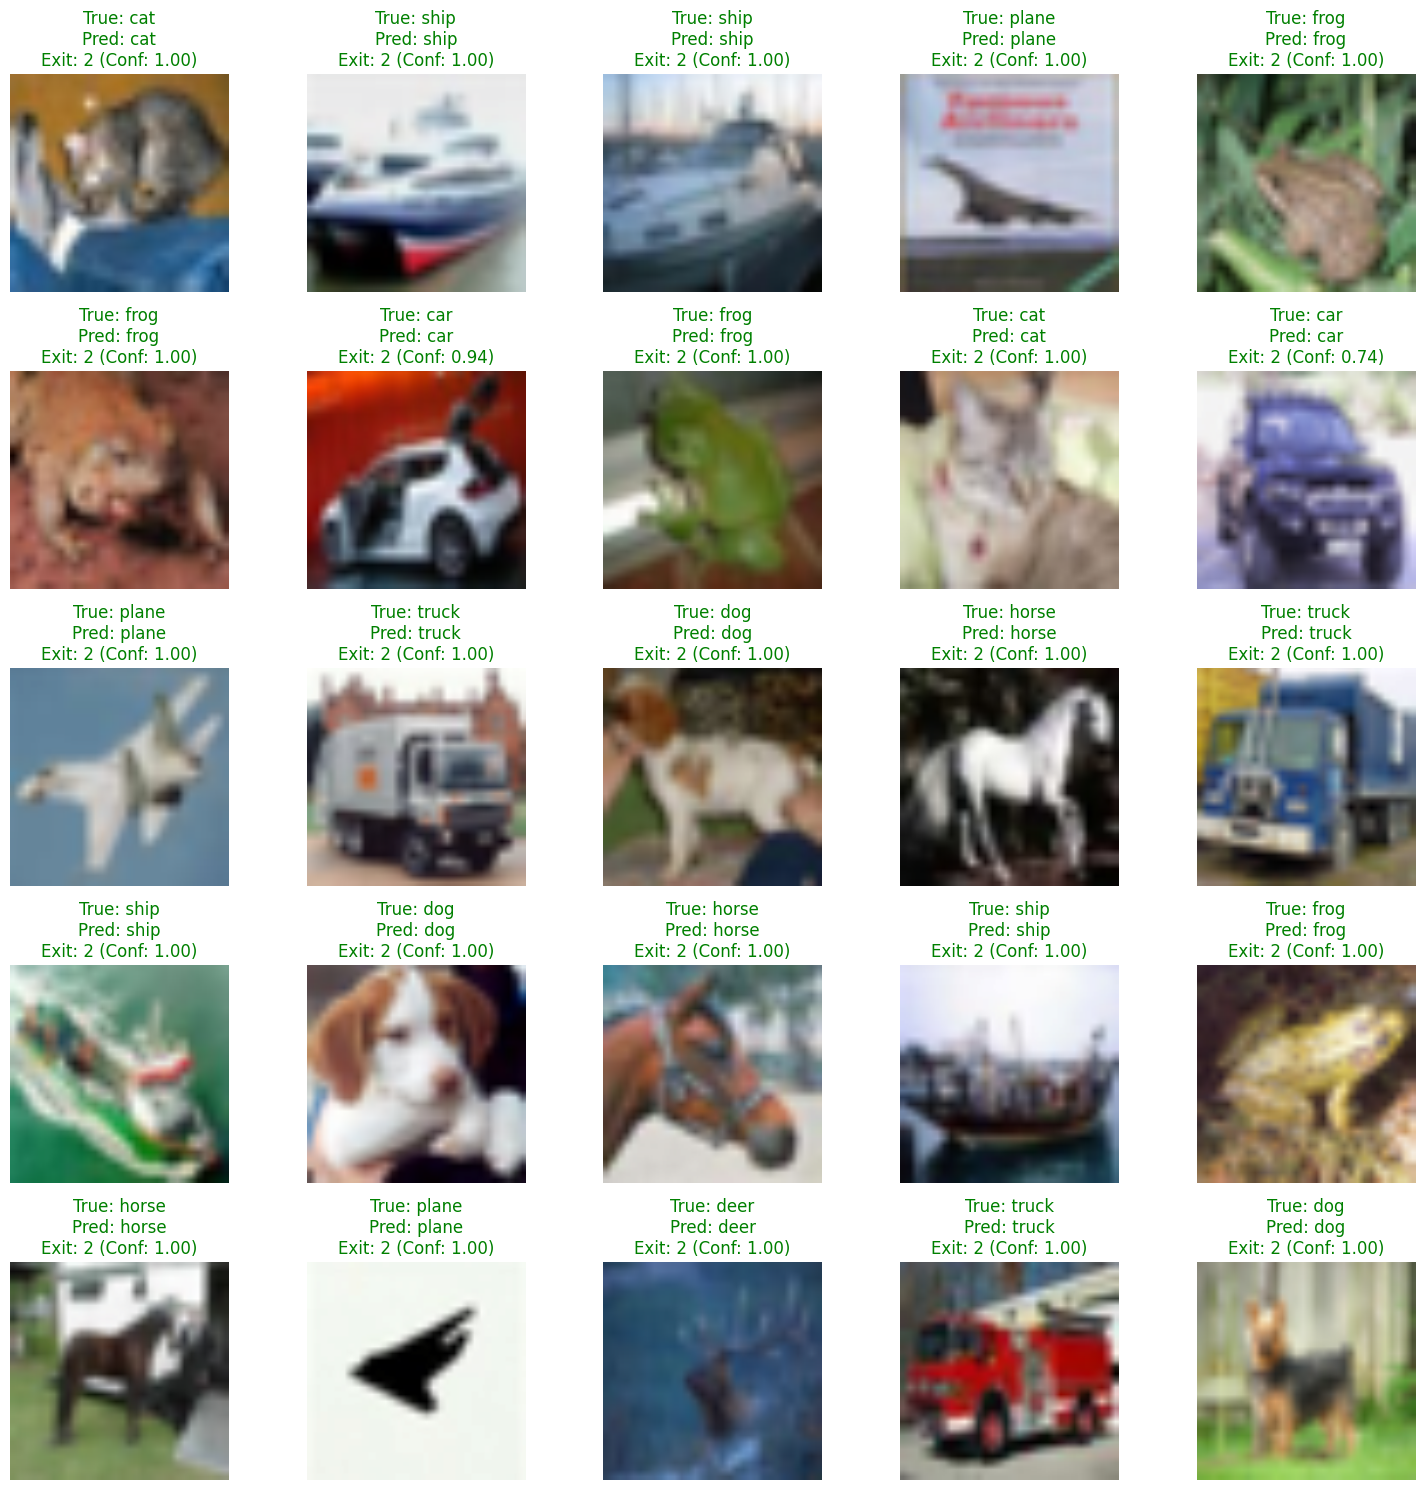

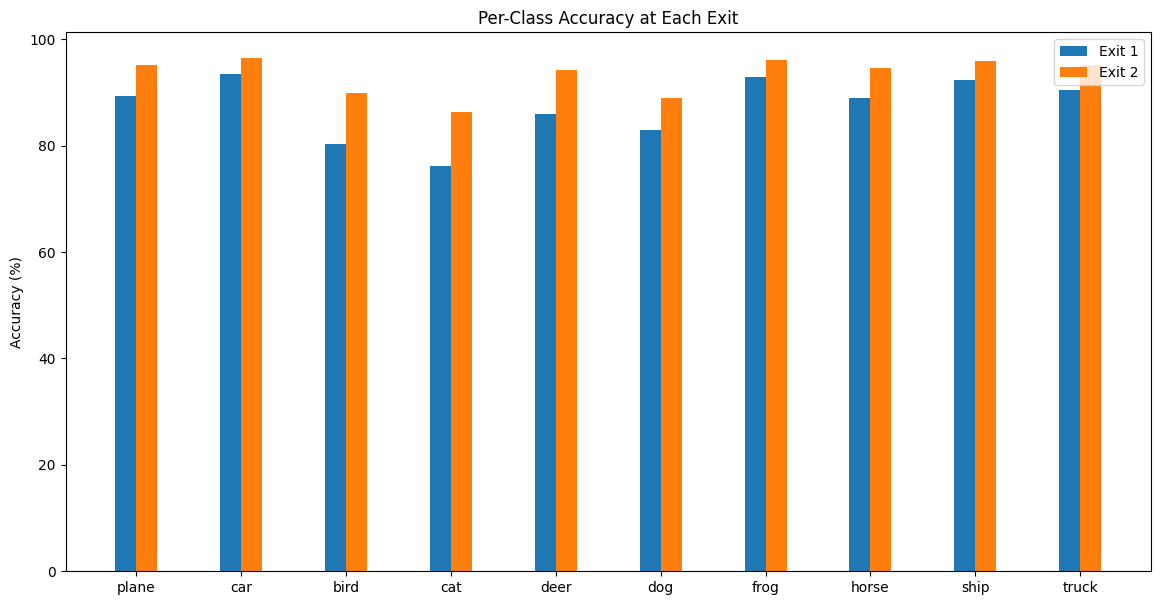

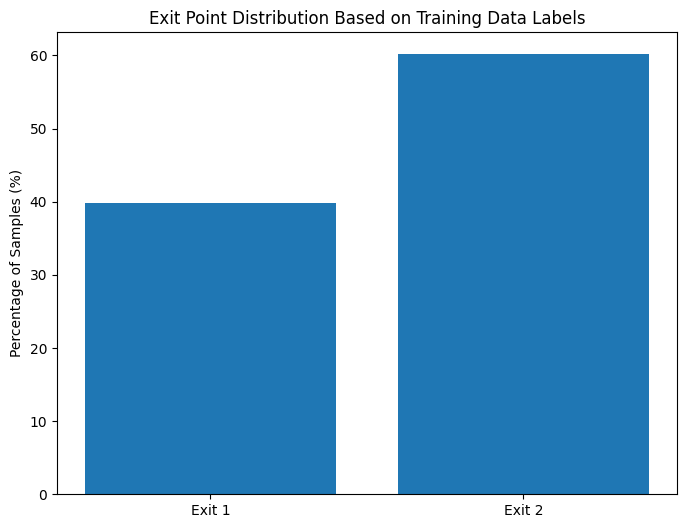


--- Experiment Complete for ResNet18 ---
Final System Test Accuracy: 93.30%


In [17]:
resnet_model, resnet_predictor, resnet_metrics = run_experiment(EarlyExitResNet, "ResNet18")


Running Experiment for: VGG16
Using device: cuda


Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:02<00:00, 205MB/s]


Let's use 2 GPUs!
Detected 3 total exits for this model.
--- Stage 1, Phase 1: Fine-tuning Exit Heads for EarlyExitVGG ---


Phase 1 Epoch 1/30:   0%|          | 0/196 [00:00<?, ?it/s]

Phase 1 Epoch 2/30:   0%|          | 0/196 [00:00<?, ?it/s]

Phase 1 Epoch 3/30:   0%|          | 0/196 [00:00<?, ?it/s]

Phase 1 Epoch 4/30:   0%|          | 0/196 [00:00<?, ?it/s]

Phase 1 Epoch 5/30:   0%|          | 0/196 [00:00<?, ?it/s]

Phase 1 Epoch 6/30:   0%|          | 0/196 [00:00<?, ?it/s]

Phase 1 Epoch 7/30:   0%|          | 0/196 [00:00<?, ?it/s]

Phase 1 Epoch 8/30:   0%|          | 0/196 [00:00<?, ?it/s]

Phase 1 Epoch 9/30:   0%|          | 0/196 [00:00<?, ?it/s]

Phase 1 Epoch 10/30:   0%|          | 0/196 [00:00<?, ?it/s]

Phase 1 Epoch 11/30:   0%|          | 0/196 [00:00<?, ?it/s]

Phase 1 Epoch 12/30:   0%|          | 0/196 [00:00<?, ?it/s]

Phase 1 Epoch 13/30:   0%|          | 0/196 [00:00<?, ?it/s]

Phase 1 Epoch 14/30:   0%|          | 0/196 [00:00<?, ?it/s]

Phase 1 Epoch 15/30:   0%|          | 0/196 [00:00<?, ?it/s]

Phase 1 Epoch 16/30:   0%|          | 0/196 [00:00<?, ?it/s]

Phase 1 Epoch 17/30:   0%|          | 0/196 [00:00<?, ?it/s]

Phase 1 Epoch 18/30:   0%|          | 0/196 [00:00<?, ?it/s]

Phase 1 Epoch 19/30:   0%|          | 0/196 [00:00<?, ?it/s]

Phase 1 Epoch 20/30:   0%|          | 0/196 [00:00<?, ?it/s]

Phase 1 Epoch 21/30:   0%|          | 0/196 [00:00<?, ?it/s]

Phase 1 Epoch 22/30:   0%|          | 0/196 [00:00<?, ?it/s]

Phase 1 Epoch 23/30:   0%|          | 0/196 [00:00<?, ?it/s]

Phase 1 Epoch 24/30:   0%|          | 0/196 [00:00<?, ?it/s]

Phase 1 Epoch 25/30:   0%|          | 0/196 [00:00<?, ?it/s]

Phase 1 Epoch 26/30:   0%|          | 0/196 [00:00<?, ?it/s]

Phase 1 Epoch 27/30:   0%|          | 0/196 [00:00<?, ?it/s]

Phase 1 Epoch 28/30:   0%|          | 0/196 [00:00<?, ?it/s]

Phase 1 Epoch 29/30:   0%|          | 0/196 [00:00<?, ?it/s]

Phase 1 Epoch 30/30:   0%|          | 0/196 [00:00<?, ?it/s]


--- Stage 1, Phase 2: Fine-tuning all layers for EarlyExitVGG ---


Phase 2 Epoch 1/20:   0%|          | 0/196 [00:00<?, ?it/s]

Phase 2 Epoch 2/20:   0%|          | 0/196 [00:00<?, ?it/s]

Phase 2 Epoch 3/20:   0%|          | 0/196 [00:00<?, ?it/s]

Phase 2 Epoch 4/20:   0%|          | 0/196 [00:00<?, ?it/s]

Phase 2 Epoch 5/20:   0%|          | 0/196 [00:00<?, ?it/s]

Phase 2 Epoch 6/20:   0%|          | 0/196 [00:00<?, ?it/s]

Phase 2 Epoch 7/20:   0%|          | 0/196 [00:00<?, ?it/s]

Phase 2 Epoch 8/20:   0%|          | 0/196 [00:00<?, ?it/s]

Phase 2 Epoch 9/20:   0%|          | 0/196 [00:00<?, ?it/s]

Phase 2 Epoch 10/20:   0%|          | 0/196 [00:00<?, ?it/s]

Phase 2 Epoch 11/20:   0%|          | 0/196 [00:00<?, ?it/s]

Phase 2 Epoch 12/20:   0%|          | 0/196 [00:00<?, ?it/s]

Phase 2 Epoch 13/20:   0%|          | 0/196 [00:00<?, ?it/s]

Phase 2 Epoch 14/20:   0%|          | 0/196 [00:00<?, ?it/s]

Phase 2 Epoch 15/20:   0%|          | 0/196 [00:00<?, ?it/s]

Phase 2 Epoch 16/20:   0%|          | 0/196 [00:00<?, ?it/s]

Phase 2 Epoch 17/20:   0%|          | 0/196 [00:00<?, ?it/s]

Phase 2 Epoch 18/20:   0%|          | 0/196 [00:00<?, ?it/s]

Phase 2 Epoch 19/20:   0%|          | 0/196 [00:00<?, ?it/s]

Phase 2 Epoch 20/20:   0%|          | 0/196 [00:00<?, ?it/s]

Two-phase fine-tuning completed.
\n--- Intermediate Evaluation: Main Model Final Exit Accuracy ---


Evaluating Main Model:   0%|          | 0/40 [00:00<?, ?it/s]

Accuracy of the main model's final exit on the test set: 90.82%
\n--- Stages 2 & 3: Incrementally generating labels and training ExitPredictor ---


Epoch 1/20:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 2/20:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 3/20:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 4/20:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 5/20:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 6/20:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 7/20:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 8/20:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 9/20:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 10/20:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 11/20:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 12/20:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 13/20:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 14/20:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 15/20:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 16/20:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 17/20:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 18/20:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 19/20:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 20/20:   0%|          | 0/196 [00:00<?, ?it/s]

ExitPredictor training completed.
Generating final label distribution for plotting...


Generating final labels:   0%|          | 0/196 [00:00<?, ?it/s]

\n--- Final Evaluation ---


Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

\nOverall Accuracy: 88.28%
Exit Distribution: ['0.0%', '66.5%', '33.5%']
Average Computational Cost: 8.34 (relative units)
Total Cost without Early Exit: 10.00
Estimated Compute Saved: 16.62%


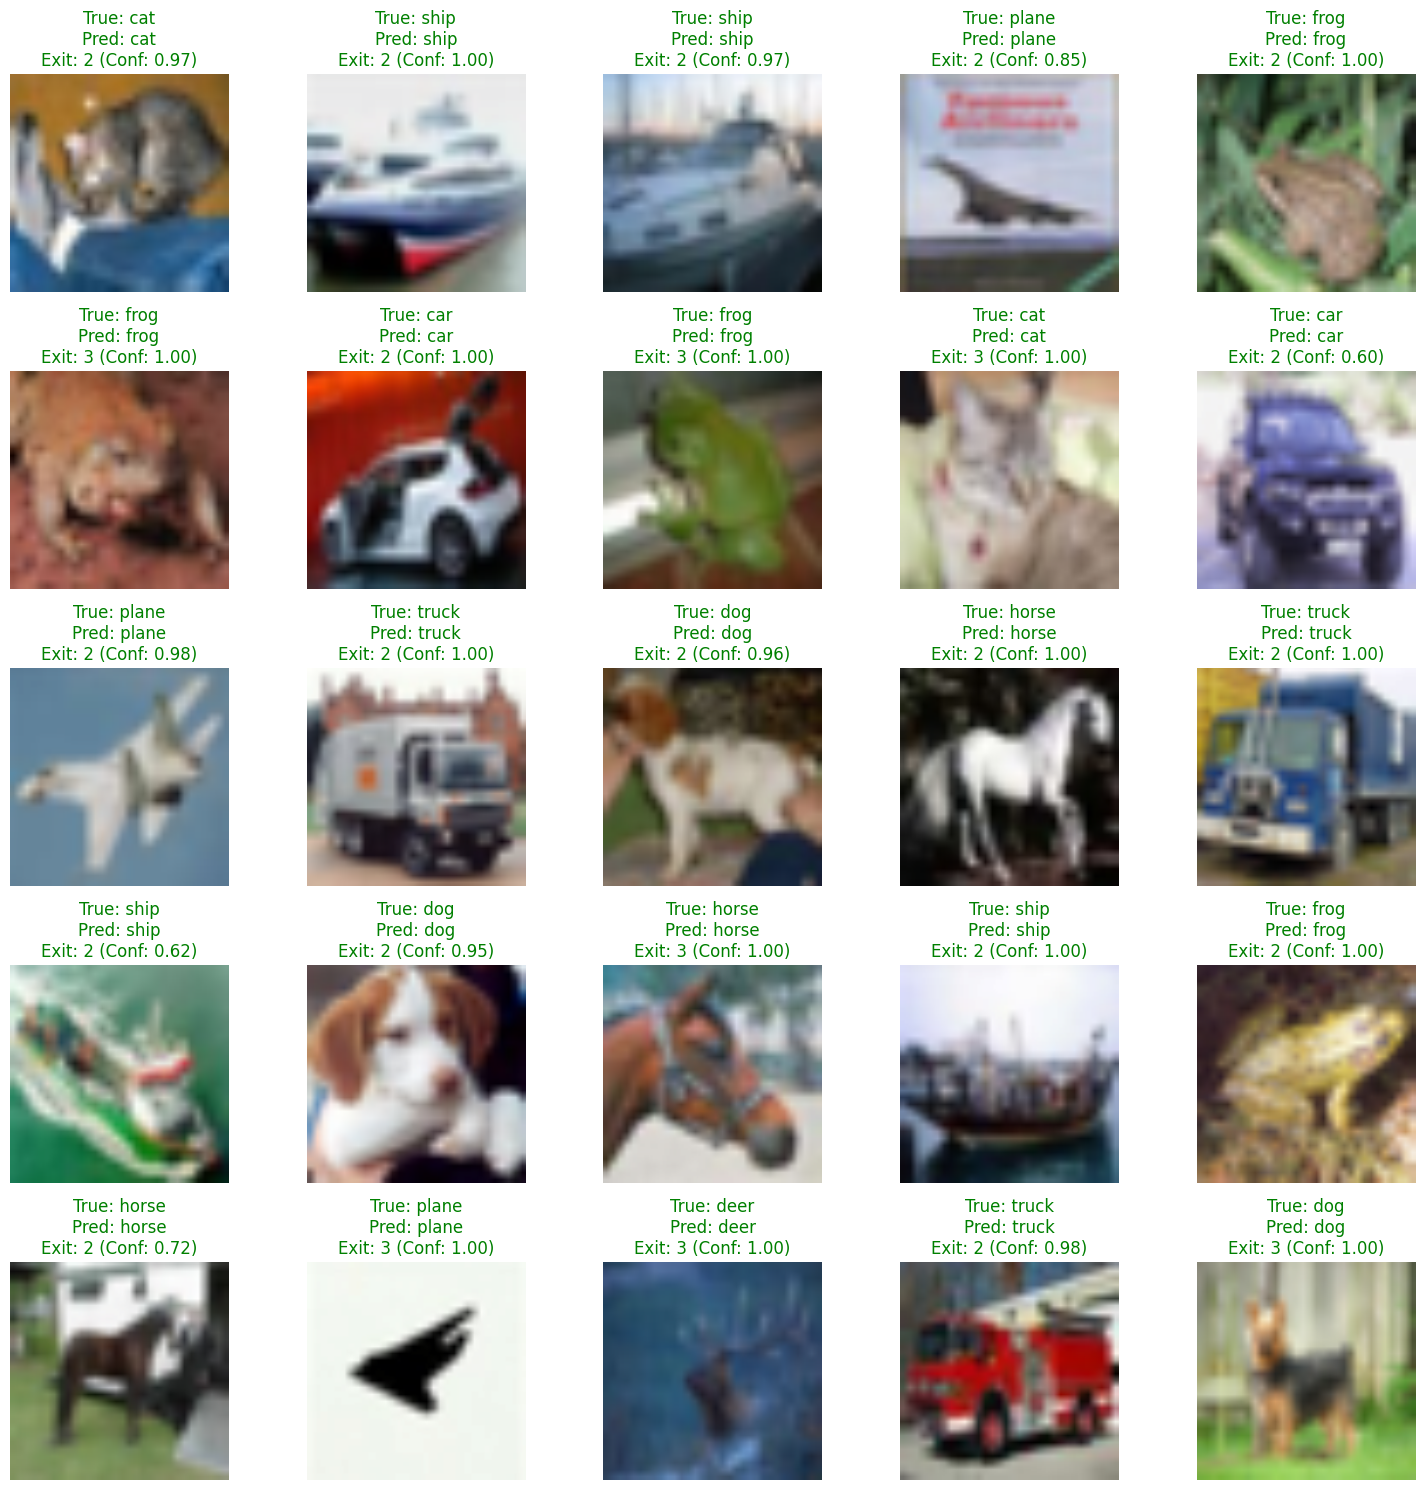

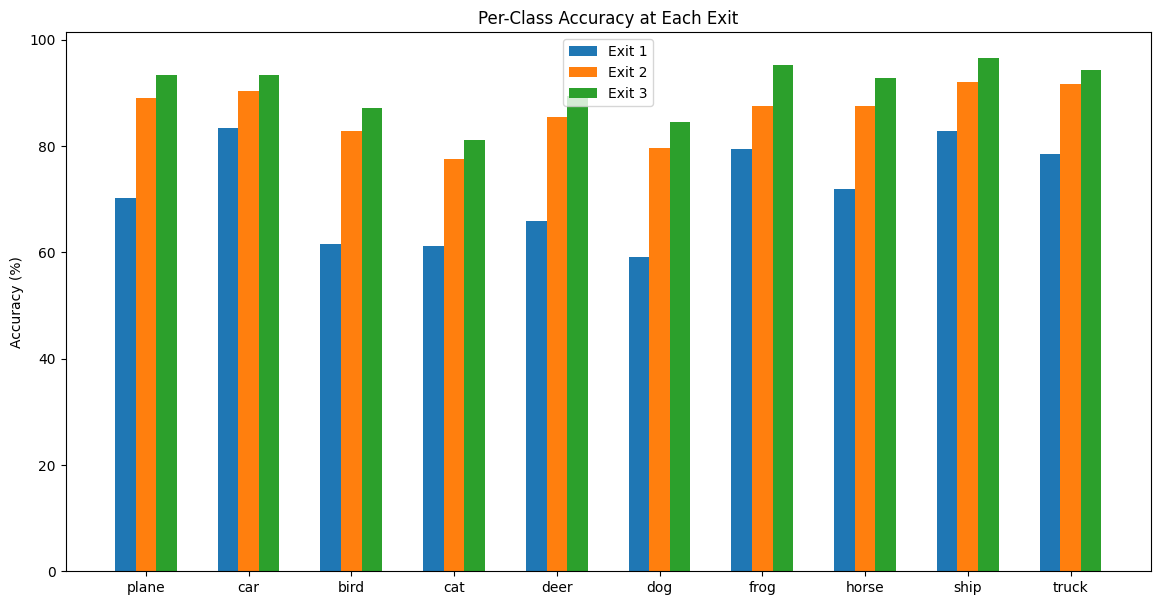

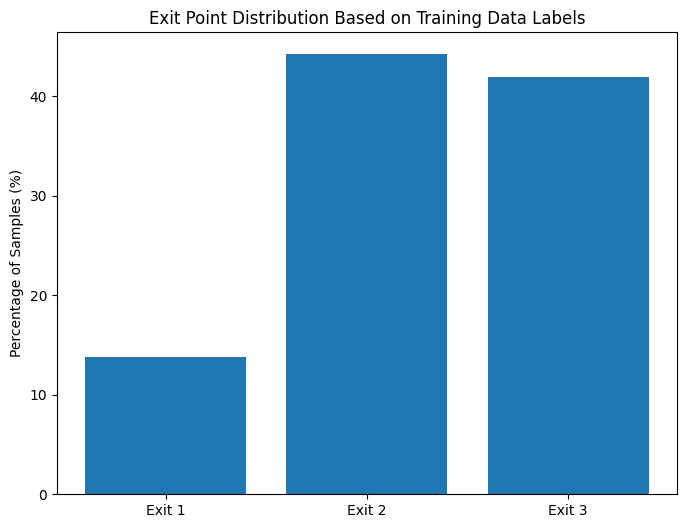


--- Experiment Complete for VGG16 ---
Final System Test Accuracy: 88.28%


In [18]:
vgg_model, vgg_predictor, vgg_metrics = run_experiment(EarlyExitVGG, "VGG16")